In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import save_image
import os
from PIL import Image
import random
from PIL import Image

from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader


In [3]:
import copy


datasets = {}


def register(name):
    def decorator(cls):
        datasets[name] = cls
        return cls
    return decorator


def make(dataset_spec, args=None):
    if args is not None:
        dataset_args = copy.deepcopy(dataset_spec['args'])
        dataset_args.update(args)
    else:
        dataset_args = dataset_spec['args']
    dataset = datasets[dataset_spec['name']](**dataset_args)
    return dataset


In [4]:
class Resampler(torch.nn.Module):

    def __init__(self, inp_size, interpolation_mode, resampling_factor):
        super(Resampler, self).__init__()
        self.inp_size = inp_size
        self.resampling_factor = resampling_factor
        self.interpolation_mode = InterpolationMode(interpolation_mode)
    
    def forward(self, img):
        new_size = self.inp_size // self.resampling_factor

        downsampler = transforms.Resize(size=(new_size,new_size), interpolation=self.interpolation_mode)
        upsampler = transforms.Resize(size=(self.inp_size, self.inp_size), interpolation=self.interpolation_mode)
        
        downsampled_image = downsampler.forward(img)
        transformed_image = upsampler.forward(downsampled_image)

        return transformed_image


@register('image-folder')
class ImageFolder(Dataset):
    def __init__(self, path,  split_file=None, split_key=None, first_k=None, size=None,
                 repeat=1, cache='none', mask=False):
        self.repeat = repeat
        self.cache = cache
        self.path = path
        self.Train = False
        self.split_key = split_key

        self.size = size
        self.mask = mask
        if self.mask:
            self.img_transform = transforms.Compose([
                transforms.Resize((self.size, self.size), interpolation=Image.NEAREST),
                transforms.ToTensor(),
            ])
        else:
            self.img_transform = transforms.Compose([
                transforms.Resize((self.size, self.size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

        if split_file is None:
            filenames = sorted(os.listdir(path))
        else:
            with open(split_file, 'r') as f:
                filenames = json.load(f)[split_key]
        if first_k is not None:
            filenames = filenames[:first_k]

        self.files = []

        for filename in filenames:
            file = os.path.join(path, filename)
            self.append_file(file)

    def append_file(self, file):
        if self.cache == 'none':
            self.files.append(file)
        elif self.cache == 'in_memory':
            self.files.append(self.img_process(file))

    def __len__(self):
        return len(self.files) * self.repeat

    def __getitem__(self, idx):
        x = self.files[idx % len(self.files)]

        if self.cache == 'none':
            return self.img_process(x)
        elif self.cache == 'in_memory':
            return x

    def img_process(self, file):
        if self.mask:
            return Image.open(file).convert('L')
        else:
            return Image.open(file).convert('RGB')

@register('paired-image-folders')
class PairedImageFolders(Dataset):

    def __init__(self, root_path_1, root_path_2, **kwargs):
        self.dataset_1 = ImageFolder(root_path_1, **kwargs)
        self.dataset_2 = ImageFolder(root_path_2, **kwargs, mask=True)

    def __len__(self):
        return len(self.dataset_1)

    def __getitem__(self, idx):
        return self.dataset_1[idx], self.dataset_2[idx]


@register('train')
class TrainDataset(Dataset):
    def __init__(self, dataset, size_min=None, size_max=None, inp_size=None,
                 augment=False, interpolation_mode="nearest", resampling_factor = 1, gt_resize=None):
        self.dataset = dataset
        self.size_min = size_min
        if size_max is None:
            size_max = size_min
        self.size_max = size_max
        self.augment = augment
        self.gt_resize = gt_resize

        self.inp_size = inp_size
        self.img_transform = transforms.Compose([
                transforms.Resize((self.inp_size, self.inp_size)),
                Resampler(inp_size = inp_size, interpolation_mode=interpolation_mode, resampling_factor=resampling_factor),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        self.inverse_transform = transforms.Compose([
                transforms.Normalize(mean=[0., 0., 0.],
                                     std=[1/0.229, 1/0.224, 1/0.225]),
                transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1, 1, 1])
            ])
        self.mask_transform = transforms.Compose([
                transforms.Resize((self.inp_size, self.inp_size)),
                Resampler(inp_size = inp_size, interpolation_mode=interpolation_mode, resampling_factor=resampling_factor),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]

        # random filp
        if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

        img = transforms.Resize((self.inp_size, self.inp_size))(img)
        mask = transforms.Resize((self.inp_size, self.inp_size), interpolation=InterpolationMode.NEAREST)(mask)

        return {
            'inp': self.img_transform(img),
            'gt': self.mask_transform(mask)
        }

In [5]:
def make_data_loader(spec, tag=''):
    if spec is None:
        return None

    dataset = make(spec['dataset'])
    dataset = make(spec['wrapper'], args={'dataset': dataset})

    loader = DataLoader(dataset, batch_size=spec['batch_size'],
        shuffle=True, num_workers=8, pin_memory=True)
    return loader


In [6]:
import yaml
inp_size = 1024
interpolation_mode = 'bicubic'
resampling_factor = 1
config_file = "visualize.yaml"

# load config 
with open(config_file, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)


In [7]:
train_loader = make_data_loader(config.get('train_dataset'), tag='train')

In [8]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/visualize')

In [17]:
# get some random training images
# for batch in train_loader:
#         # for k, v in batch.items():
#         #     batch[k] = v.to(device)
#         inp = batch['inp']
#         gt = batch['gt']
batch = train_loader.__iter__().__next__()
gt = batch['gt']
# convert gt to binary int tensor
gt = (gt > 0).int()
pred = torch.rand(gt.shape)
# pred = torch.zeros(gt.shape, dtype=torch.float32)
print(gt.dtype)
print(pred.shape)

torch.int32
torch.Size([4, 1, 1024, 1024])


In [10]:
from torchmetrics.classification import BinaryPrecisionRecallCurve
pr_curve = BinaryPrecisionRecallCurve()
pr_curve.update(pred, gt)
precision, recall, thresholds = pr_curve.compute()
precision.shape, recall.shape, thresholds.shape
precision.squeeze().shape, recall.squeeze().shape, thresholds.squeeze().shape

(torch.Size([2]), torch.Size([2]), torch.Size([]))

In [18]:
writer.add_pr_curve('pr_curve', gt, pred, 0)

In [21]:
pred_good = torch.load('/home/kandelaki/git/SAM-Adapter-PyTorch/examples/pred_19')
gt_good = torch.load('/home/kandelaki/git/SAM-Adapter-PyTorch/examples/gt_19')\

pred_bad = torch.load('/home/kandelaki/git/SAM-Adapter-PyTorch/examples/pred_13')
gt_bad = torch.load('/home/kandelaki/git/SAM-Adapter-PyTorch/examples/gt_13')\



In [22]:
writer.add_pr_curve('pr_curve_good', gt_good, pred_good, 0)
writer.add_pr_curve('pr_curve_bad', gt_bad, pred_bad, 0)

In [23]:
pred_good.shape

torch.Size([1, 1, 1024, 1024])

In [41]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('metrics')

from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.classification import Dice
# calculate jaccard index of the predictions
folder_path = "/home/kandelaki/git/SAM-Adapter-PyTorch/examples/"
# iterate over files folderpath
from torchmetrics.aggregation import MeanMetric
jaccard = BinaryJaccardIndex()
mean_jaccard = MeanMetric()
jaccard.reset()
mean_jaccard.reset()

dice_cur = Dice()
mean_dice = MeanMetric()

for i in range(20):
    
    pred = torch.load(folder_path + "pred_" + str(i))
    gt = torch.load(folder_path + "gt_" + str(i))
    gt = (gt > 0).int()

    jaccard.update(pred, gt)
    cur_index = jaccard.compute()
    writer.add_scalar('jacard1', jaccard.compute(), i)
    mean_jaccard.update(cur_index)
    mean_jaccard_cur = mean_jaccard.compute()
    writer.add_scalar('mean_jacard1', mean_jaccard_cur, i)

    dice_cur.update(pred, gt)
    cur_dice = dice_cur.compute()
    writer.add_scalar('dice1', cur_dice, i)
    mean_dice.update(cur_dice)
    mean_dice_cur = mean_dice.compute()
    writer.add_scalar('mean_dice1', mean_dice_cur, i)




In [1]:
# torch.save(batch['gt'], (f"examples/gt_{cnt}"))
        # torch.save(pred, (f"examples/pred_{cnt}"))
        # # Save predicted images as png files    
        
        # pred_mask = pred.cpu()
        # pred_mask = pred_mask.squeeze(0)
        # pred_mask = tensor2PIL(pred_mask)
       
        # pred_mask.save(f'predicted/pred_{cnt}.png')
        
        # gt_img = batch['gt']
        # gt_img = gt_img.cpu()
        # gt_img = gt_img.squeeze(0)
        # gt_img = tensor2PIL(gt_img)
        # gt_img.save(f'predicted/gt_{cnt}.png')

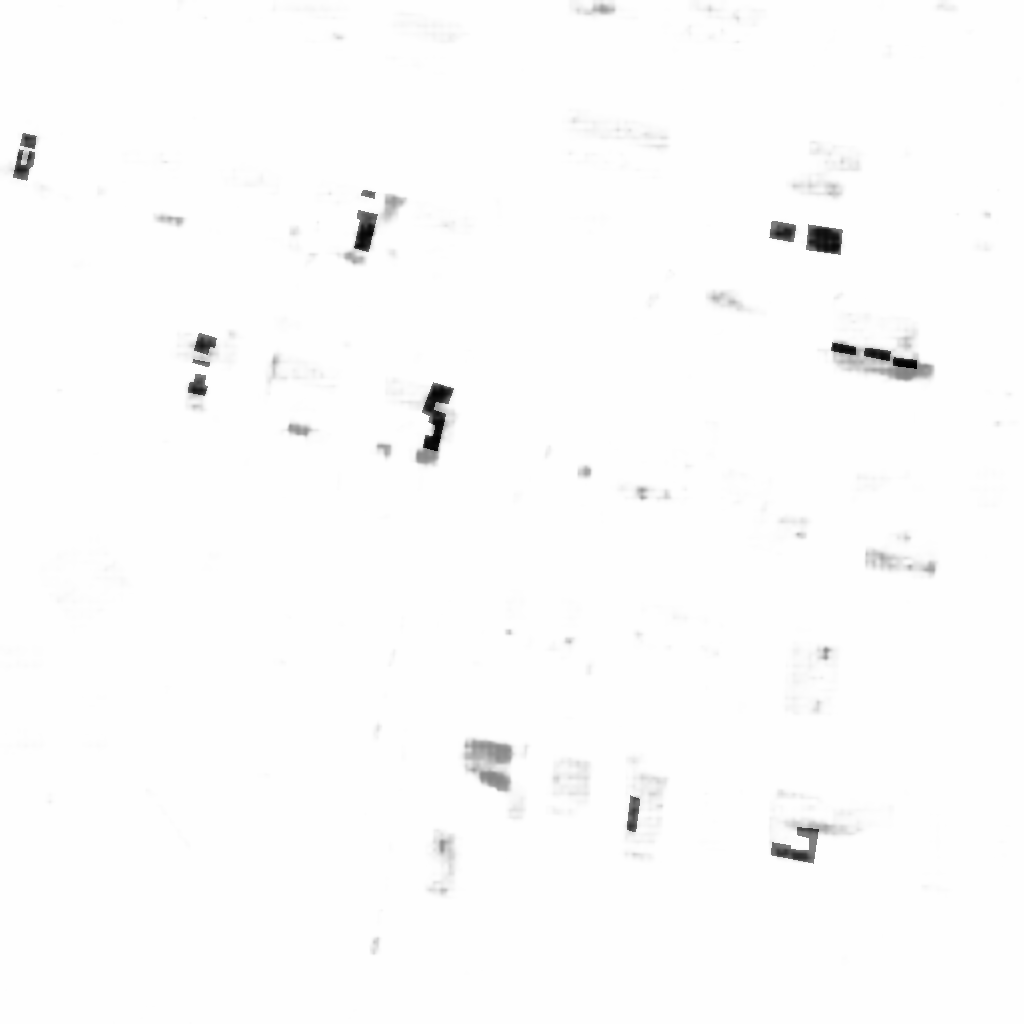

In [29]:
from PIL import Image
import torch
from torchvision import transforms
gt = torch.load('/home/kandelaki/git/SAM-Adapter-PyTorch/examples/gt_0')
pred = torch.load('/home/kandelaki/git/SAM-Adapter-PyTorch/examples/pred_0')

# print mask with PIL
def tensor2PIL(tensor): 
    tensor = tensor.squeeze(0)     
    image = transforms.ToPILImage()(tensor)
    return image

pred_mask = tensor2PIL(pred)

gt_img = tensor2PIL(gt)

pred_mask.convert('RGB')

blended = Image.blend(pred_mask, gt_img, alpha=0.5)
blended.show()